In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np
from src.transforms import resize_pad
import onnxruntime as ort
from PIL import Image
from src.results import DetectionResults
import matplotlib.pyplot as plt


class OnnxModel:
    def __init__(self, path):
        self.initialize_model(path)

    def initialize_model(self, path):
        self.session = ort.InferenceSession(
            path, providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
        )
        # Get model info
        model_inputs = self.session.get_inputs()
        self.input_names = [model_inputs[i].name for i in range(len(model_inputs))]
        model_outputs = self.session.get_outputs()
        self.output_names = [model_outputs[i].name for i in range(len(model_outputs))]
        _, c, h, w = model_inputs[0].shape
        self.bbox_divider = np.array([w, h, w, h])
        self.input_w = w
        self.input_h = h
        self.input_c = c


class YoloOnnxModel(OnnxModel):
    def __init__(self, path, conf_thres=0.7, iou_thres=0.5):
        super().__init__(path)
        self.conf_threshold = conf_thres
        self.iou_threshold = iou_thres

    def __call__(self, image):
        return self.detect_objects(image)

    def prepare_input(self, image):
        image = image[..., : self.input_c]
        image, ratio, pad = resize_pad(image, self.input_w, self.input_h)
        image = image / 255.0
        image = image.transpose(2, 0, 1)
        input_tensor = np.expand_dims(image, 0).astype(np.float32)
        return input_tensor, ratio, pad

    def detect_objects(self, image: np.ndarray):
        input_image = np.copy(image)
        input_tensor, ratio, pad = self.prepare_input(input_image)
        outputs = self.inference(input_tensor)
        results = self.process_output(input_image, outputs, ratio, pad)
        return results

    def process_output(
        self, input_image, outputs, ratio, pad: tuple[float, float]
    ) -> DetectionResults:
        predictions = np.squeeze(outputs[0]).T

        # Filter out object confidence scores below threshold
        conf = np.max(predictions[:, 4:], axis=1)
        predictions = predictions[conf > self.conf_threshold, :]
        conf = conf[conf > self.conf_threshold]

        if len(conf) == 0:
            return DetectionResults(orig_image=input_image)

        # Get the class with the highest confidence
        class_ids = np.argmax(predictions[:, 4:], axis=1)

        pad_x, pad_y = pad
        ratio_x, ratio_y = ratio

        boxes_xywh = predictions[:, :4]
        boxes_xywh[:, 0] -= pad_x
        boxes_xywh[:, 1] -= pad_y
        w = self.input_w - pad_x * 2  # / ratio_x
        h = self.input_h - pad_y * 2  # / ratio_y
        boxes_xywh = np.divide(boxes_xywh, np.array([ratio_x, ratio_y, ratio_x, ratio_y]))
        orig_w = w / ratio_x
        orig_h = h / ratio_y
        results = DetectionResults(input_image, boxes_xywh, class_ids, conf, orig_w, orig_h)

        results.non_maximum_supression(self.iou_threshold)
        return results

    def inference(self, input_tensor):
        return self.session.run(self.output_names, {self.input_names[0]: input_tensor})


In [19]:
onnx_model = YoloOnnxModel("../models/model2.onnx")

/home/shate/.cache/pypoetry/virtualenvs/digits-detection-hppNHGvS-py3.11/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


In [31]:
img = Image.open("../datasets/SVHN/examples/2.png")
img = np.asarray(img)[..., :3]

In [36]:
import torchvision.transforms as T
from torch import nn
import cv2
import torch

In [51]:
class InputTransform(nn.Module):
    def __init__(self, input_h, input_w, fill_value=114):
        self.model_h = input_h
        self.model_w = input_w
        self.fill_value = fill_value
        super().__init__()
        
    def _resize_pad(self, image):
        image = image.permute(2, 0, 1) # HWC -> CHW for torch resize
        img_c, img_h, img_w = image.shape
        aspect_ratio = img_w / img_h
        if aspect_ratio > 1:
            new_img_w = self.model_w
            new_img_h = int(self.model_w / aspect_ratio)
        else:
            new_img_h = self.model_h
            new_img_w = int(self.model_h / aspect_ratio)
        resized_img = T.functional.resize(image, (new_img_h, new_img_w)).permute(1, 2, 0) # CHW -> HWC

        # width, height ratios
        ratio_x = new_img_w / img_w
        ratio_y = new_img_h / img_h
        padded_img = torch.ones(self.model_h, self.model_w, img_c) * self.fill_value
        left = (self.model_w - new_img_w) // 2
        bottom = (self.model_h - new_img_h) // 2

        padded_img[bottom : bottom + new_img_h, left : left + new_img_w] = resized_img
        pad_x = (self.model_w - new_img_w) // 2
        pad_y = (self.model_h - new_img_h) // 2
        return padded_img, (ratio_x, ratio_y), (pad_x, pad_y)
        
    def __call__(self, image):
        image, ratio, pad = self._resize_pad(image)
        image = image / 255.0
        image = image.permute(2, 0, 1)
        input_tensor = image.unsqueeze(0).to(torch.float32)
        return input_tensor, ratio, pad

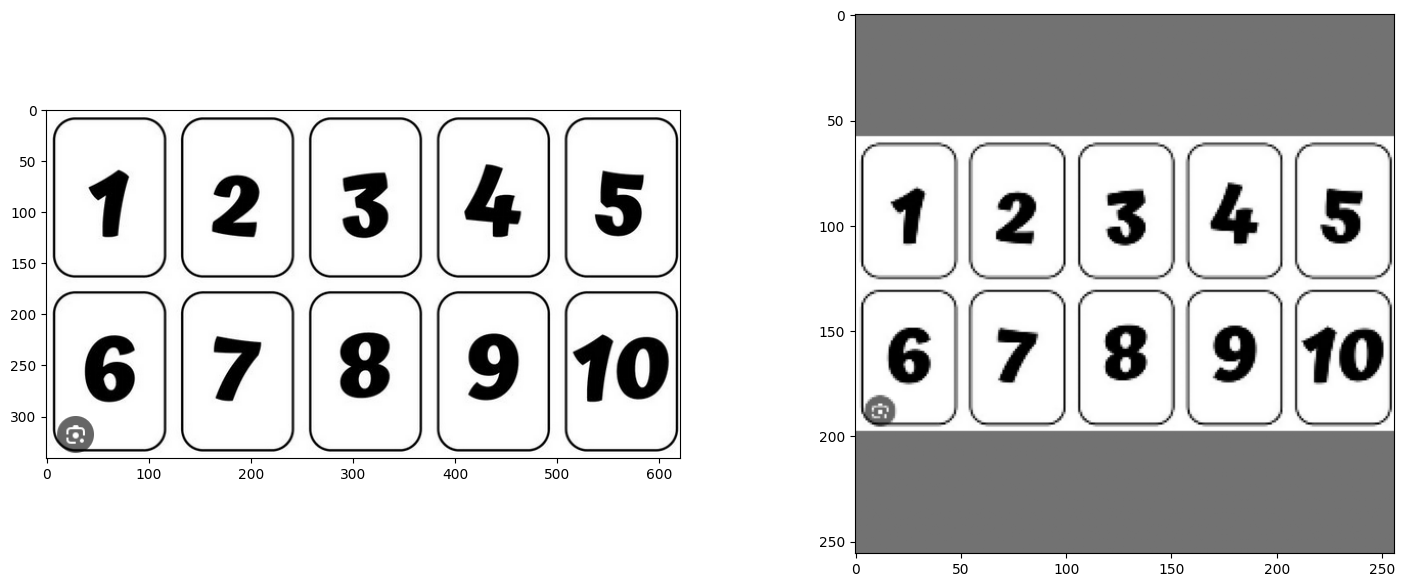

In [56]:
transformed_img = onnx_model.prepare_input(img)[0]
transformed_img = transformed_img.squeeze().transpose(1, 2, 0)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
axes[0].imshow(img)
axes[1].imshow(transformed_img)

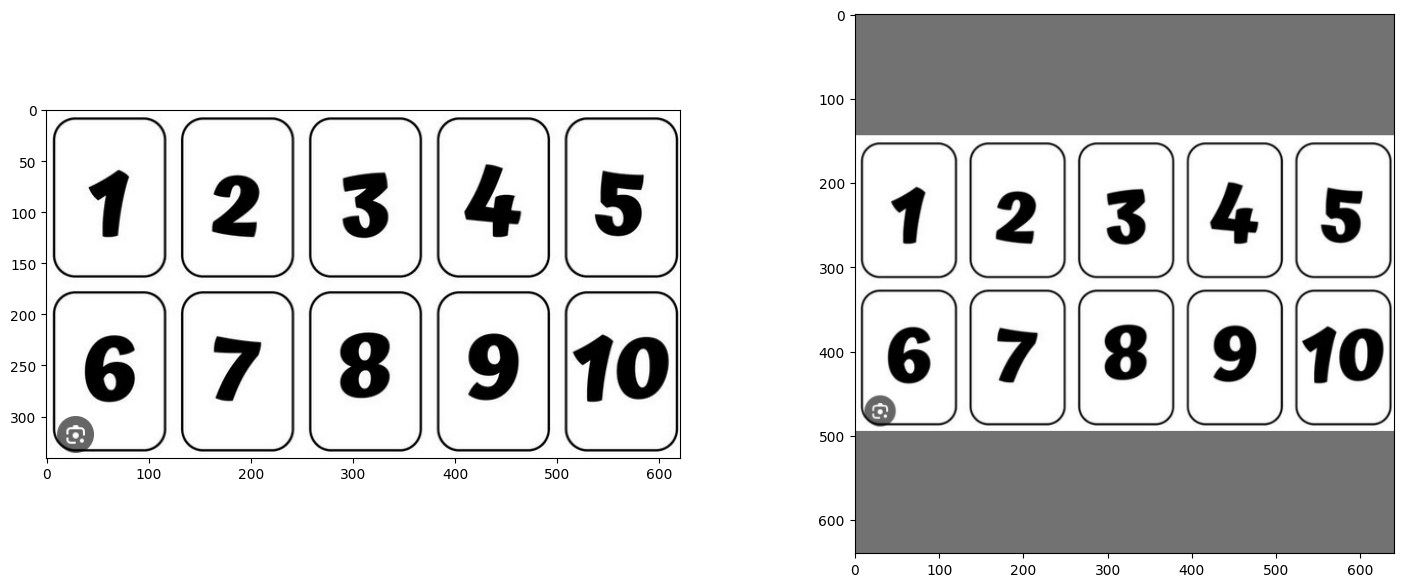

In [55]:
transform = InputTransform(640, 640)
transformed_img_2 = transform(torch.from_numpy(img))[0]
transformed_img_2 = transformed_img_2.squeeze().permute(1, 2, 0)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
axes[0].imshow(img)
axes[1].imshow(transformed_img_2)

In [ ]:
torch.onnx.export(
    transform,
    {"image": torch.random()},
    "transform.onnx",
    verbose=False,
    input_names=["image"],
    output_names=["transformed_image"],
    export_params=True,
)